In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.metrics import MSE
from tensorflow.keras.optimizers import Adadelta, SGD
from tensorflow.keras.losses import categorical_crossentropy

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

In [3]:
dataset = pd.read_csv('Sunspots.csv', delimiter=',')

In [4]:
dataset.head()

,Index,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


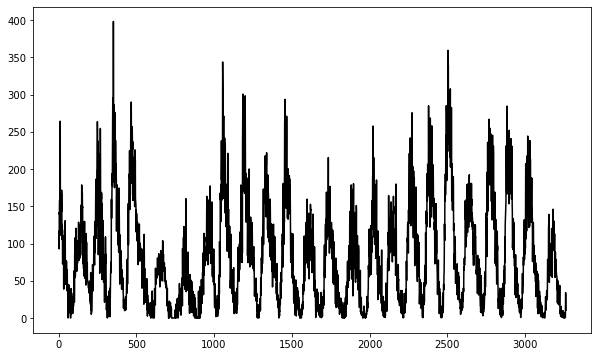

In [5]:
tiempo = np.array(dataset['Index'])
sunspots = np.array(dataset['Monthly Mean Total Sunspot Number'])

plt.figure(figsize=(10, 6))
plt.plot(tiempo, sunspots, color='black')
plt.show()

In [6]:
split_tiempo = 3000
tiempo_train = tiempo[:split_tiempo]
x_train = sunspots[:split_tiempo]
tiempo_valid = tiempo[split_tiempo:]
x_valid = sunspots[split_tiempo:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [8]:
print(x_valid.shape)

(265,)


In [9]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
dataset_val = windowed_dataset(x_valid, window_size, x_valid.shape[0], x_valid.shape[0])

In [10]:
for features, label in dataset:
    print("Features:", features.numpy(), "Label:", label.numpy())

Features: [[ 20.   21.2  20.  ...   1.2   0.    1.7]
 [ 64.2  57.5  83.3 ...  21.2  20.    9.5]
 [ 25.8  25.6  51.5 ... 120.1 141.  177.3]
 ...
 [ 72.   78.  109.  ... 286.2 260.5 250.5]
 [ 50.   46.7  64.5 ... 262.2 261.7 235.8]
 [138.3 149.5 185.8 ... 128.7 122.8 107. ]] Label: [  2.2  13.3 110.5  13.1  32.6  11.8  32.5  43.4 188.3  82.6   7.5  13.7
 116.8 153.7 169.   49.3  10.   77.2 159.5  54.5   0.   58.3  20.   58.7
   4.6 150.   30.8  95.  128.5 175.  290.  118.3]
Features: [[238.8 180.8 188.3 ...  93.3  93.3  91.7]
 [124.5  97.2 120.  ...  42.8  40.   43.3]
 [ 40.3  26.7  50.  ... 174.5 162.8 122.5]
 ...
 [102.4  72.6  55.2 ... 135.4 146.1 112.9]
 [ 89.4  82.6  93.5 ...  68.9  44.5  23.3]
 [123.2 107.  107.2 ...  43.8  68.2  72. ]] Label: [ 92.5  41.7 110.  146.1  60.8  35.2   0.   67.5  21.2   0.  163.3  43.8
  18.3  25.5 127.3 235.   30.2  21.5 135.4   0.    0.  163.3  62.7   1.
  68.3  41.7 112.8  57.  228.9 109.8  14.8  78. ]
Features: [[  9.8  16.6   8.2 ... 131.3 122.7 1

Features: [[  8.4   8.5  14.7 ... 167.5 148.2 156.7]
 [ 19.2  41.3  50.9 ...  91.2 141.3 218.8]
 [ 84.3  97.1  50.2 ...  53.7  60.   37.8]
 ...
 [ 42.6  37.5  27.5 ... 117.1 109.6  57.3]
 [ 70.7  74.2  66.3 ... 126.4  79.8  96. ]
 [  0.    8.2   7.6 ... 109.5  88.3 124.5]] Label: [1.519e+02 2.211e+02 5.960e+01 2.200e+00 2.560e+01 1.950e+01 7.590e+01
 3.610e+01 2.000e-01 4.600e+00 1.880e+01 9.110e+01 0.000e+00 4.800e+01
 1.120e+01 1.028e+02 7.620e+01 1.000e+01 1.732e+02 5.730e+01 1.351e+02
 1.160e+01 6.700e+00 9.610e+01 6.700e+00 8.020e+01 8.500e+01 4.930e+01
 6.800e+00 9.010e+01 7.760e+01 1.199e+02]
Features: [[ 53.9  75.9  65.9 ...   2.9   0.4   2. ]
 [ 11.6   9.5  19.3 ... 211.1 229.4 157.6]
 [102.5  78.9  65.4 ...   0.5  15.9   7.6]
 ...
 [  4.9  14.   21.7 ...  65.7  69.8  84.3]
 [ 25.   17.5  21.7 ... 226.7 235.  236.7]
 [  9.5  14.5  25.7 ... 162.6 176.3 187.7]] Label: [  5.2 180.4   1.9 131.9 190.2  10.8  38.6  29.7 109.3   9.1 120.4  20.5
  53.9  43.7 122.5 114.1  88.3 120.6  6

Features: [[136.2 154.8 166.  ...  81.8  60.3  56.1]
 [ 42.2  63.4  48.8 ...  98.5 114.2  91.9]
 [282.6 205.6 157.7 ...  14.3  13.5   4.8]
 ...
 [ 88.7 107.  102.5 ... 112.5 175.9 110.8]
 [ 38.5  20.4  45.4 ...  70.2  84.1  99.1]
 [  8.5   5.    1.  ... 162.6 275.6 192.8]] Label: [3.320e+01 9.400e+01 1.380e+01 7.620e+01 1.284e+02 3.000e+00 8.000e-01
 2.470e+01 1.261e+02 7.230e+01 2.035e+02 2.101e+02 4.980e+01 1.139e+02
 5.350e+01 9.910e+01 7.710e+01 4.040e+01 2.000e-01 3.590e+01 2.050e+01
 1.505e+02 3.190e+01 5.970e+01 1.183e+02 2.309e+02 1.016e+02 1.290e+01
 4.830e+01 9.150e+01 1.389e+02 1.493e+02]
Features: [[ 90.7  86.9  59.2 ...  54.9  30.6  43. ]
 [ 10.6   3.8   4.8 ... 215.6 120.3 160.7]
 [ 34.2  21.   44.4 ... 143.   74.6 125.7]
 ...
 [128.2 112.5 119.1 ...  15.7  22.8  14.4]
 [ 25.5  18.1  47.9 ... 176.  155.  191.1]
 [ 49.   48.7  51.7 ...   6.4   0.    9.3]] Label: [ 62.4 215.5 142.2 151.8  35.3  45.7  32.8  13.6  25.5 153.7 194.4 115.5
  13.   22.8  59.6 286.7 138.8  67.1  2

In [11]:
for features, label in dataset_val:
    print("Features:", features.numpy(), "Label:", label.numpy())
    print("Features:", features.numpy().shape, "Label:", label.numpy().shape)

Features: [[ 86.6  85.9  96.5 ...  18.5  26.1  26.4]
 [ 13.9  18.8  25.2 ...  66.7  54.5  75.3]
 [ 74.8  59.2  72.8 ...   1.    1.3   1.2]
 ...
 [  2.9   6.3   5.5 ... 146.1 128.7 112.5]
 [ 78.6  63.6  62.2 ...   5.8   6.1   7.5]
 [217.7 191.5 165.9 ...  28.9  48.1  43.5]] Label: [ 17.7  88.8   0.6  21.8  47.8  15.6   1.5  76.5 130.    0.9   6.1  83.8
   4.    1.1  26.1   5.2  20.8 112.9  93.   17.8   8.9  78.6  37.2  22.3
  18.5   1.2   1.3  37.2   5.7   7.2  90.   63.6  74.6  29.6 107.3  50.2
 103.6   0.5   6.3 113.9   3.3   7.7  24.5   0.6  64.5  48.1  29.3   6.8
  78.6   1.2  13.2  33.6  32.3   5.7   2.9  13.2 112.5 120.2  72.8  75.3
   1.   62.2  56.1  43.7   9.4  14.4 109.3  61.9  37.9  54.1   5.4  10.4
 146.1  76.7  66.5  66.5  50.3   4.9   3.1  24.   19.5  70.1  62.4  64.4
  28.5  65.8   0.2  44.6  86.2  74.2  54.5 100.2  13.1   4.2  94.4 120.1
  91.8   8.7  20.9  59.2  34.   58.   87.6 139.1   6.2  21.4  18.9   7.5
   1.6  24.5  14.9 114.4   0.3 106.9   0.    7.7   0.8  60.9  

In [12]:
# Model
#---------------------------------------------------------------------#
input_layer = Input(shape=[window_size])
dense_1 = Dense(20, activation='relu') (input_layer)
#dropout_1 = Dropout(0.25) (dense_1) # ctrl + /
dense_2 = Dense(10, activation='relu') (dense_1)
#dense_2 = Dense(500, activation='relu') (dropout_1)
#dropout_2 = Dropout(0.25) (dense_2)
# dense_3 = Dense(100, activation='relu') (dense_2)
output_layer = Dense(1) (dense_2)
#---------------------------------------------------------------------#
model = Model(input_layer, output_layer)

SGD_optimizer = SGD(learning_rate=1e-7, momentum=0.9)
model.compile(optimizer=SGD_optimizer, loss='mse', metrics=['mae'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 dense (Dense)               (None, 20)                1220      
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [13]:
epochs = 100
start_time = time.time()
history = model.fit(dataset, epochs=epochs, batch_size=batch_size, validation_data=dataset_val, shuffle=True, verbose=1)
end_time = time.time()
print('\nElapsed Dense Model training time: {:.5f} seconds'.format(end_time-start_time))

Epoch 1/100
92/92 [==============================] - 3s 27ms/step - loss: 1473.7690 - mae: 28.0630 - val_loss: 363.8415 - val_mae: 13.8547
Epoch 2/100
92/92 [==============================] - 1s 6ms/step - loss: 907.1813 - mae: 22.4709 - val_loss: 327.5269 - val_mae: 13.0359
Epoch 3/100
92/92 [==============================] - 1s 6ms/step - loss: 815.0975 - mae: 21.2902 - val_loss: 315.6894 - val_mae: 13.0987
Epoch 4/100
92/92 [==============================] - 1s 6ms/step - loss: 787.6503 - mae: 20.8372 - val_loss: 306.2974 - val_mae: 12.8615
Epoch 5/100
92/92 [==============================] - 1s 5ms/step - loss: 753.6014 - mae: 20.3590 - val_loss: 292.4382 - val_mae: 12.5375
Epoch 6/100
92/92 [==============================] - 1s 7ms/step - loss: 737.6123 - mae: 20.0642 - val_loss: 279.6583 - val_mae: 12.0656
Epoch 7/100
92/92 [==============================] - 1s 5ms/step - loss: 730.9741 - mae: 19.9311 - val_loss: 290.2730 - val_mae: 12.5433
Epoch 8/100
92/92 [====================

92/92 [==============================] - 1s 7ms/step - loss: 585.2775 - mae: 17.4274 - val_loss: 238.1637 - val_mae: 11.0773
Epoch 61/100
92/92 [==============================] - 1s 8ms/step - loss: 579.7722 - mae: 17.4709 - val_loss: 233.9939 - val_mae: 10.9626
Epoch 62/100
92/92 [==============================] - 1s 6ms/step - loss: 577.1527 - mae: 17.3559 - val_loss: 233.0701 - val_mae: 10.8305
Epoch 63/100
92/92 [==============================] - 1s 6ms/step - loss: 575.2302 - mae: 17.3104 - val_loss: 236.2394 - val_mae: 10.7409
Epoch 64/100
92/92 [==============================] - 1s 7ms/step - loss: 582.1262 - mae: 17.4639 - val_loss: 233.7384 - val_mae: 10.7015
Epoch 65/100
92/92 [==============================] - 1s 8ms/step - loss: 578.8632 - mae: 17.4095 - val_loss: 233.6283 - val_mae: 10.9799
Epoch 66/100
92/92 [==============================] - 1s 8ms/step - loss: 576.5350 - mae: 17.4018 - val_loss: 231.4666 - val_mae: 10.7397
Epoch 67/100
92/92 [===========================

In [ ]:
start_time = time.time()
forecast=[]
for indice in range(len(sunspots) - window_size):
    forecast.append(model.predict(sunspots[indice:indice + window_size][np.newaxis], verbose=0))

forecast = forecast[split_tiempo-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))
plt.plot(tiempo_valid, x_valid)
plt.plot(tiempo_valid, results)
end_time = time.time()
print('\nModel simulation time: {:.5f} seconds'.format(end_time-start_time))

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

In [ ]:
print(results.shape)
print(sunspots.shape)